ref: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

In [29]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import sys

In [30]:
batch_size = 4
log_interval = 200
no_cuda = True
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [43]:
transform = transforms.Compose(
    [transforms.Resize(128),       # 한 축을 128로 조절하고
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(root="images/", transform=transform)

test_len = int(len(train_data) * 0.2)
train_data, test_data = data_utils.random_split(train_data, (len(train_data) - test_len, test_len))

trainloader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print('===== trainloader sample')
for i, data in enumerate(trainloader):
    print('input image: {}'.format(data[0].size()))  # input image
    print('class label: {}'.format(data[1]))         # class label
    break

print('===== testloader sample')
for i, data in enumerate(testloader):
    print('input image: {}'.format(data[0].size()))  # input image
    print('class label: {}'.format(data[1]))         # class label
    break
    
classes = ('10_20', '11_14', '13_1', '13_15', '13_16', '13_17', '13_18', '13_20', '13_6', '13_9', '3_20', '3_5', '4_11', '4_2', '4_7', '5_8', '7_1', '7_20', '8_6', '8_9')

===== trainloader sample
input image: torch.Size([4, 3, 128, 128])
class label: tensor([18, 11,  1,  5])
===== testloader sample
input image: torch.Size([4, 3, 128, 128])
class label: tensor([ 9,  0, 15, 15])


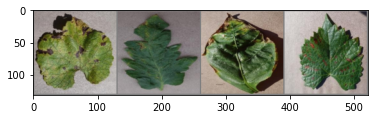

 4_11  13_1   7_1   4_7


In [44]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [45]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [46]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [47]:
def print_progress(msg, progress):
    max_progress = int((progress*100)/2)
    remain=50-max_progress
    buff="{}\t[".format( msg )
    for i in range( max_progress ): buff+="⬛"
    buff+="⬜"*remain
    buff+="]:{:.2f}%\r".format( progress*100 )
    sys.stderr.write(buff)
    
def test(log_interval, model, criterion, device, test_loader):
    model.eval()
    test_losses = []
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss = criterion(outputs, labels)
            test_losses.append(test_loss.item())
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            progress = (i + 1) / float(len(test_loader))
            print_progress('test', progress)
        print(file=sys.stderr)

    return np.mean(test_losses), 100. * correct / len(test_loader.dataset)


def train(log_interval, model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    correct = 0
    for i, data in enumerate(train_loader):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        progress = (i + 1) / float(len(train_loader))
        print_progress('train', progress)
    print(file=sys.stderr)

    return np.mean(train_losses), 100. * correct / len(train_loader.dataset)

In [36]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
date_time = datetime.now().strftime('%Y%m%d%H%M')
writer = SummaryWriter('./runs/{}'.format(date_time))


num_iters = 100
for epoch in range(1, num_iters + 1):   # 데이터셋을 수차례 반복합니다.
    tr_loss, tr_acc = train(log_interval, net, criterion, device, trainloader, optimizer, epoch)
    te_loss, te_acc = test(log_interval, net, criterion, device, testloader)

    print("{} / {}\ttrain loss, acc : {:.4f}, {:.4f}, test loss, acc: {:.4f}, {:.4f}\n".format(epoch, num_iters, tr_loss, tr_acc, te_loss, te_acc), file=sys.stderr)

    writer.add_scalar('{}/{}'.format('loss', 'train'), tr_loss, epoch)
    writer.add_scalar('{}/{}'.format('loss', 'test'), te_loss, epoch)
    writer.add_scalar('{}/{}'.format('acc', 'train'), tr_acc, epoch)
    writer.add_scalar('{}/{}'.format('acc', 'test'), te_acc, epoch)

writer.close()
print('Finished Training')


PATH = './disease_net.pth'
torch.save(net.state_dict(), PATH)

KeyboardInterrupt: 